In this colab, we will 
- Will learn how to interpret model results and reason about the features
- Visualize the model results

In [1]:
import time

# We will use some np and pandas for dealing with input data.
import numpy as np
import pandas as pd
# And of course, we need tensorflow.
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
tf.__version__

'2.3.0'

Below we demonstrate both *local* and *global* model interpretability for gradient boosted trees. 

Local interpretability refers to an understanding of a model’s predictions at the individual example level, while global interpretability refers to an understanding of the model as a whole.

For local interpretability, we show how to create and visualize per-instance contributions using the technique outlined in [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) and by Saabas in [Interpreting Random Forests](http://blog.datadive.net/interpreting-random-forests/) (this method is also available in scikit-learn for Random Forests in the [`treeinterpreter`](https://github.com/andosa/treeinterpreter) package). To distinguish this from feature importances, we refer to these values as directional feature contributions (DFCs).

For global interpretability we show how to retrieve and visualize gain-based feature importances, [permutation feature importances](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) and also show aggregated DFCs.

In [3]:
#tf.logging.set_verbosity(tf.logging.ERROR)
tf.random.set_seed(123)

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

# Feature columns.
fcol = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fcol.indicator_column(
      fcol.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
fc = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  fc.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  fc.append(fcol.numeric_column(feature_name,
                                dtype=tf.float32))

# Input functions.
def make_input_fn(X, y, n_epochs=None):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(len(y)))  # Use entire dataset since this is such a small dataset.
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1)

## Local interpretability
Output directional feature contributions (DFCs) to explain individual predictions, using the approach outlined in [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) and by Saabas in [Interpreting Random Forests](http://blog.datadive.net/interpreting-random-forests/). The DFCs are generated with:

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

In [4]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(fc, **params)
# Train model.
est.train(train_input_fn)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.814394
accuracy_baseline,0.625000
auc,0.869146
auc_precision_recall,0.852474
average_loss,0.414831
label/mean,0.375000
loss,0.414831
precision,0.760417
prediction/mean,0.388140
recall,0.737374


## Local interpretability
Next you will output the directional feature contributions (DFCs) to explain individual predictions using the approach outlined in [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) and by Saabas in [Interpreting Random Forests](http://blog.datadive.net/interpreting-random-forests/) (this method is also available in scikit-learn for Random Forests in the [`treeinterpreter`](https://github.com/andosa/treeinterpreter) package). The DFCs are generated with:

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

(Note: The method is named experimental as we may modify the API before dropping the experimental prefix.)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [7]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3vmq8f2b', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

In [11]:
def clean_feature_names(df):
    """Boilerplate code to cleans up feature names -- this is unneed in TF 2.0"""
    df.columns = [v.split(':')[0].split('_indi')[0] for v in df.columns.tolist()]
    df = df.T.groupby(level=0).sum().T
    return df

# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])


In [13]:

df_dfc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.026755,0.092524,-0.147969,-0.076613,-0.054172,0.003090,0.505813
sex,264.0,0.006561,0.107809,-0.097792,-0.074628,-0.072858,0.138226,0.182456
class,264.0,0.017197,0.093079,-0.133776,-0.043060,-0.041724,0.033055,0.231730
deck,264.0,-0.018092,0.032575,-0.094638,-0.042912,-0.032754,0.001897,0.199893
embark_town,264.0,-0.007015,0.031443,-0.056042,-0.017526,-0.015517,-0.003948,0.086491
fare,264.0,0.026746,0.089524,-0.224306,-0.028076,-0.002334,0.072627,0.285098
n_siblings_spouses,264.0,0.001387,0.026011,-0.133110,0.002419,0.003337,0.006167,0.103482
parch,264.0,0.000552,0.008971,-0.085350,0.000661,0.000873,0.001488,0.040270
alone,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

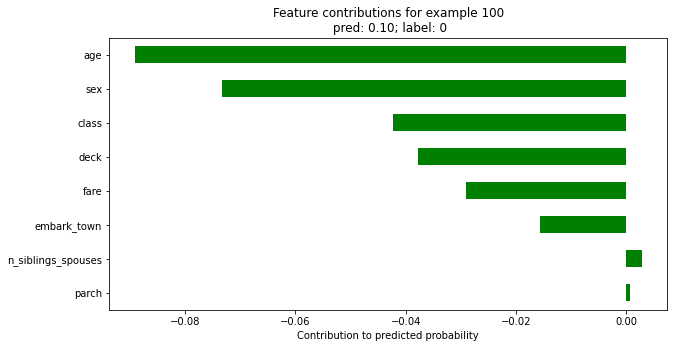

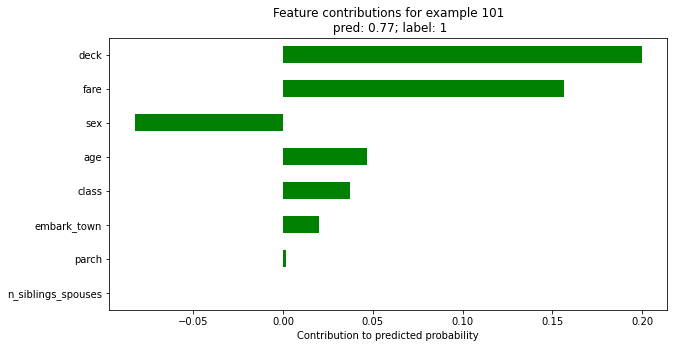

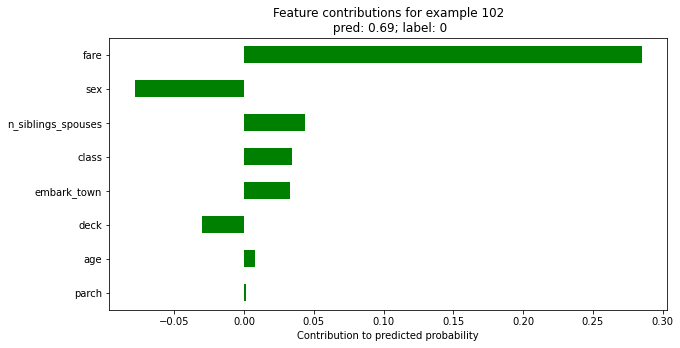

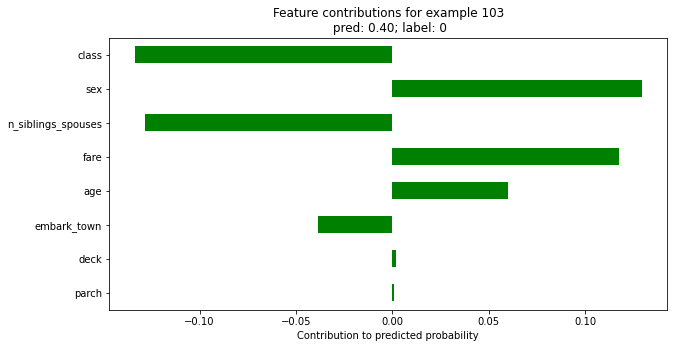

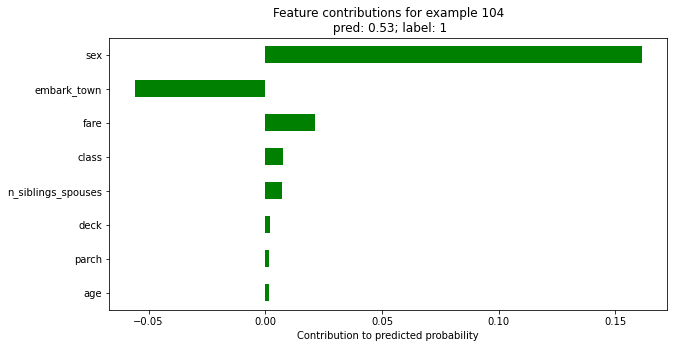

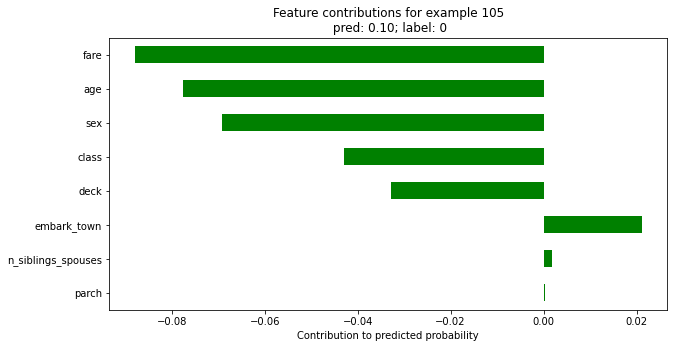

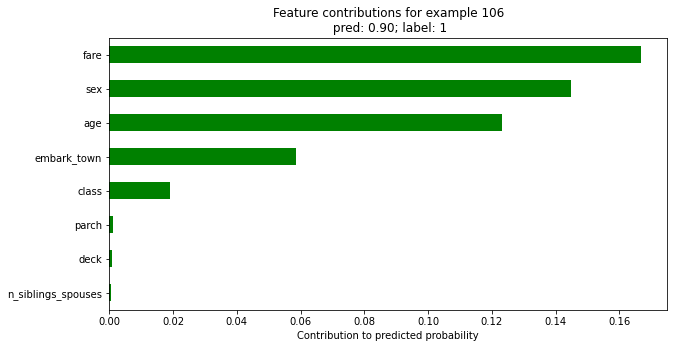

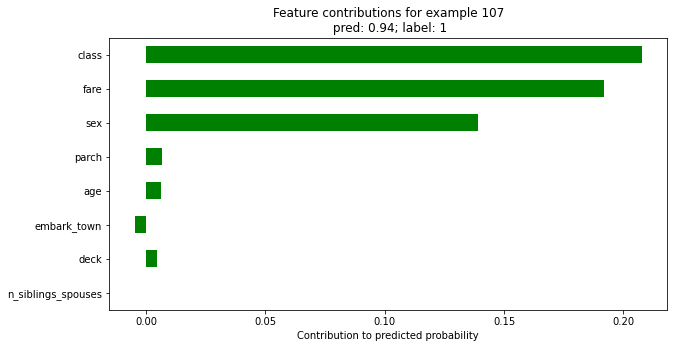

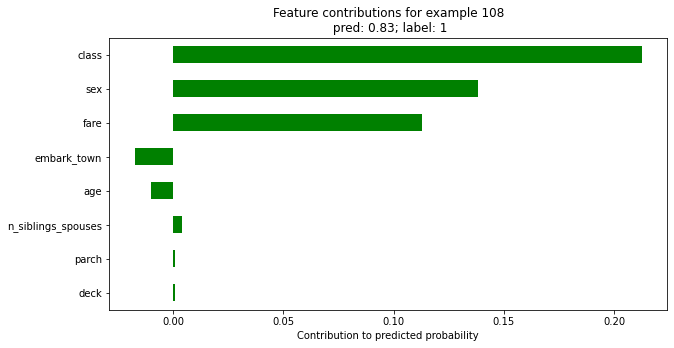

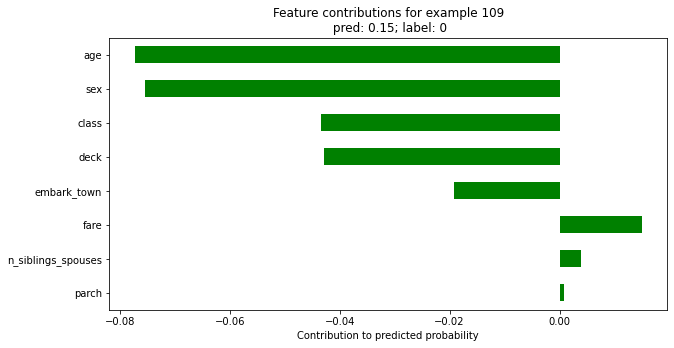

In [17]:
import seaborn as sns  # Make plotting nicer.
sns_colors = sns.color_palette('colorblind')

def plot_dfcs(example_id):
    label, prob = labels[ID], probs[ID]
    example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
    TOP_N = 8  # View top 8 features.
    sorted_ix = example.abs().sort_values()[-TOP_N:].index
    ax = example[sorted_ix].plot(kind='barh', color='g', figsize=(10,5))
    ax.grid(False, axis='y')

    plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, prob, label))
    plt.xlabel('Contribution to predicted probability')
ID = 102
for ID in range(100,110):
  plt.figure()
  plot_dfcs(ID)

In [18]:
def plot_example_pretty(example):
    """Boilerplate code for better plotting :)"""
    
    def _get_color(value):
        """To make positive DFCs plot green, negative DFCs plot red."""
        green, red = sns.color_palette()[2:4]
        if value >= 0: return green
        return red


    def _add_feature_values(feature_values, ax):
        """Display feature's values on left of plot."""
        x_coord = ax.get_xlim()[0]
        OFFSET = 0.15
        for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
            t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
            t.set_bbox(dict(facecolor='white', alpha=0.5))
        from matplotlib.font_manager import FontProperties
        font = FontProperties()
        font.set_weight('bold')
        t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
        fontproperties=font, size=12)


    TOP_N = 8 # View top 8 features.
    sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)
    _add_feature_values(dfeval.iloc[ID].loc[sorted_ix], ax)
    ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
    ax.set_xlabel('Contribution to predicted probability', size=14)
    plt.show()
    return ax

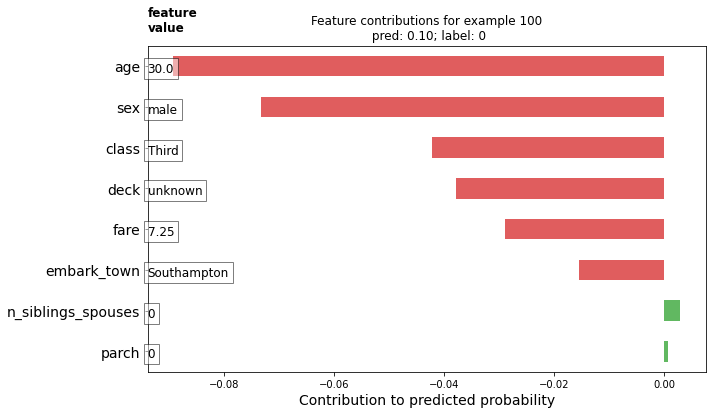

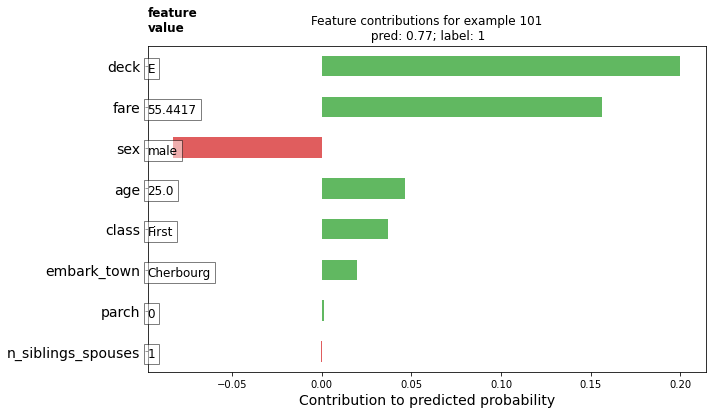

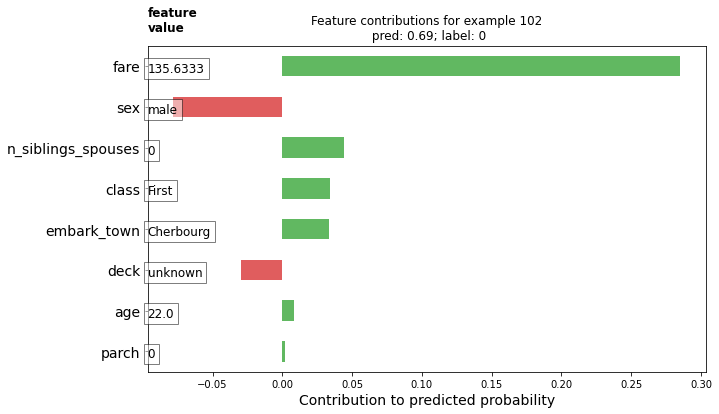

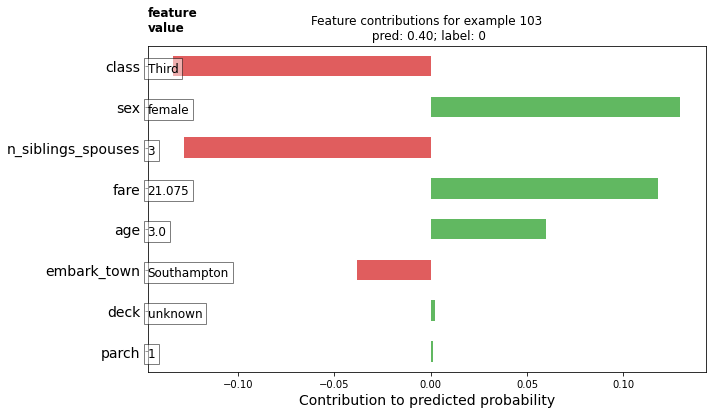

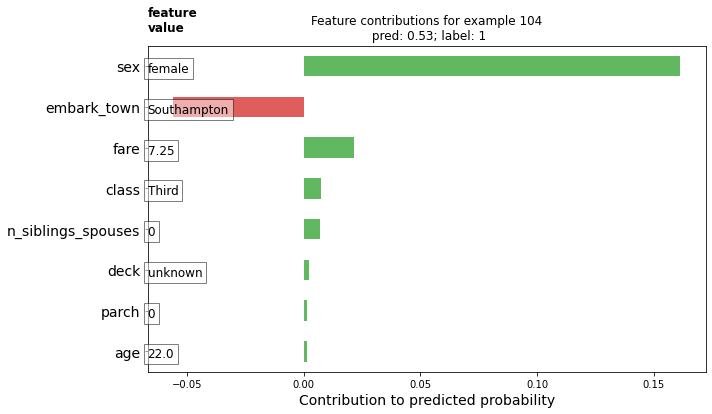

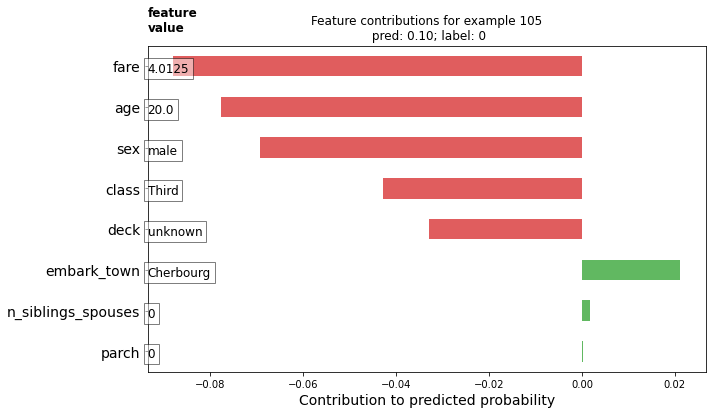

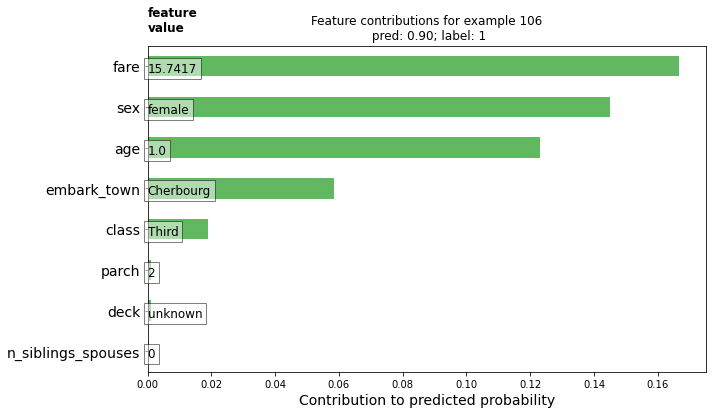

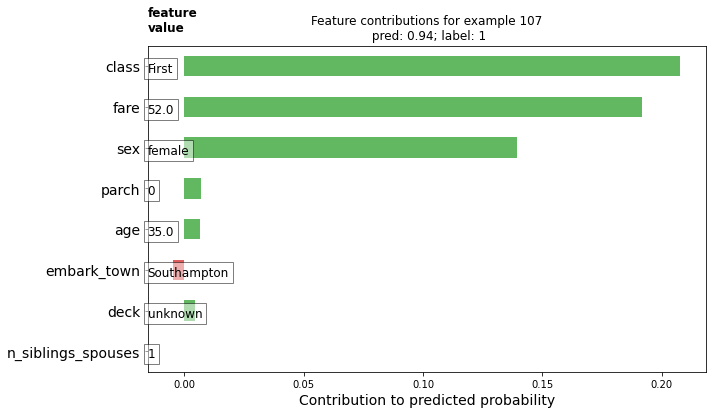

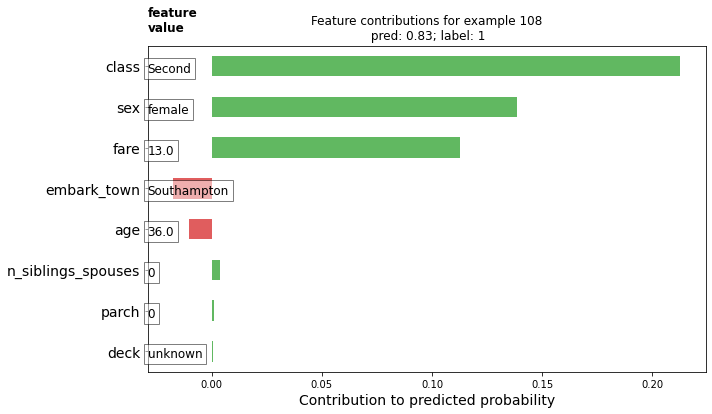

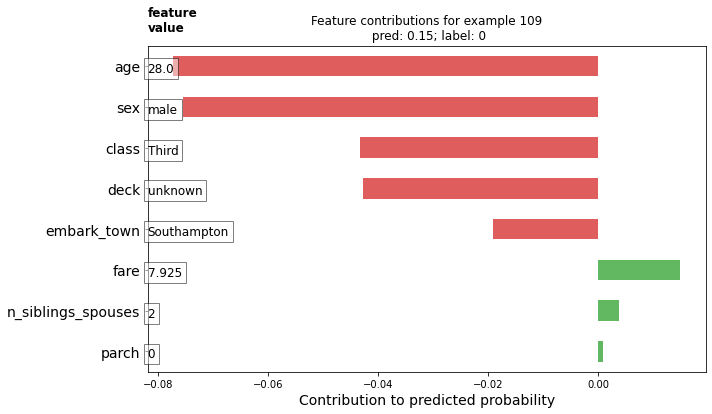

In [20]:
# Plot results.
ID = 102
for ID in range(100,110):
  
  example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
  ax = plot_example_pretty(example)

## Global feature importances

1. Gain-based feature importances using `est.experimental_feature_importances`
2. Aggregate DFCs using `est.experimental_predict_with_explanations`
3. Permutation importances

Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated ([source](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307)). Check out [this article](http://explained.ai/rf-importance/index.html) for an in-depth overview and great discussion on different feature importance types.

## 1. Gain-based feature importances

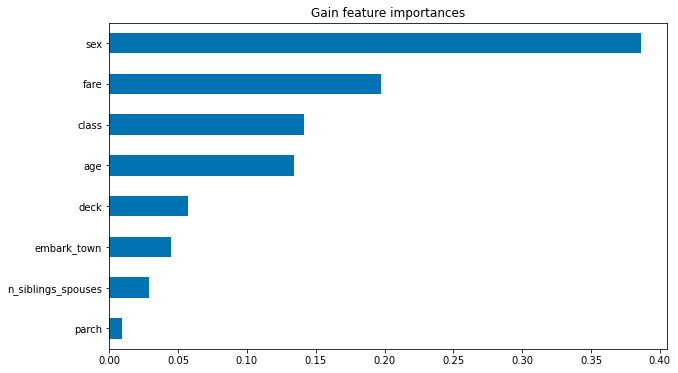

In [25]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

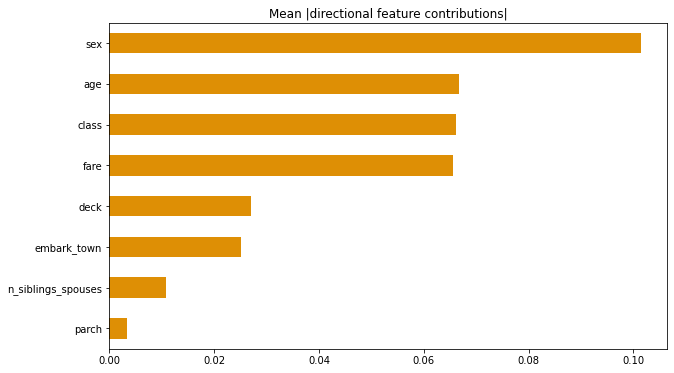

In [26]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


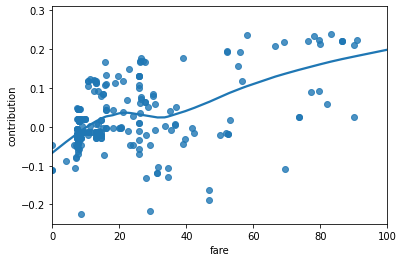

In [27]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

Permutation feature importance

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-04T02:13:25Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3vmq8f2b/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.51914s
INFO:tensorflow:Finished evaluation at 2020-12-04-02:13:25
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.81439394, accuracy_baseline = 0.625, auc = 0.869146, auc_precision_recall = 0.852474, average_loss = 0.41483065, global_step = 153, label/mean = 0.375, loss = 0.41483065, precision = 0.7604167, prediction/mean = 0.38813996, recall = 0.7373737
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmp3vmq8f2b/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-04T02:13:26Z
INFO:tensorflow:Graph was finali

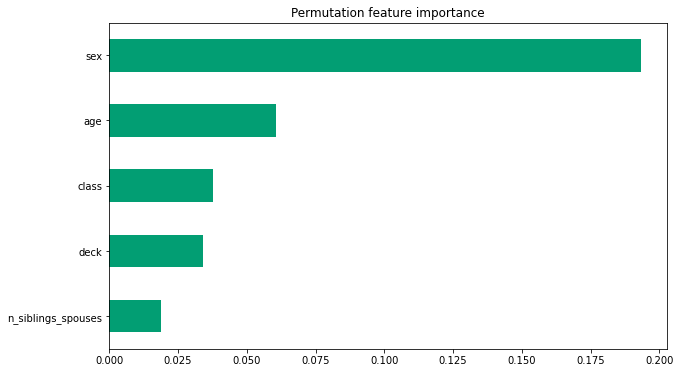

In [29]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

# Visualizing the model's prediction surface
Lets first simulate/create training data using the following formula:


$z=x* e^{-x^2 - y^2}$


Where $z$ is the dependent variable we are trying to predict and $x$ and $y$ are the features.

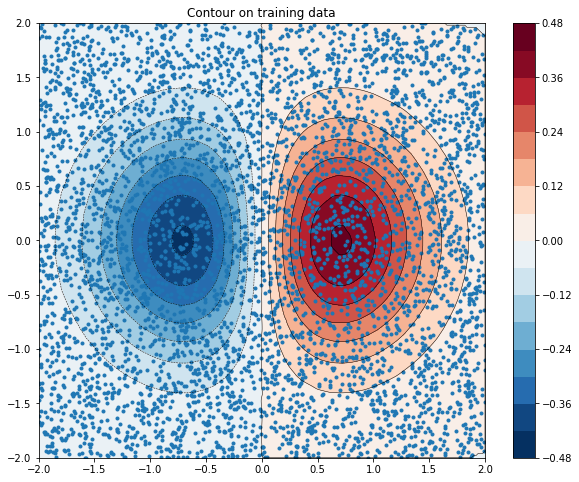

In [37]:
from numpy.random import uniform, seed
from scipy.interpolate import griddata

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)
xy = np.zeros((2,np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

def plot_contour(x, y, z, **kwargs):
  # Grid the data.
  plt.figure(figsize=(10, 8))
  # Contour the gridded data, plotting dots at the nonuniform data points.
  CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
  CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
  plt.colorbar()  # Draw colorbar.
  # Plot data points.
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)



#You can visualize the function. Redder colors correspond to larger function values.


zi = griddata(xy, z, (xi, yi), method='linear', fill_value='0')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [38]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

def predict(est):
  """Predictions from a given estimator."""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)
#First let's try to fit a linear model to the data.


train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvj7ujs_c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructio

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvj7ujs_c/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


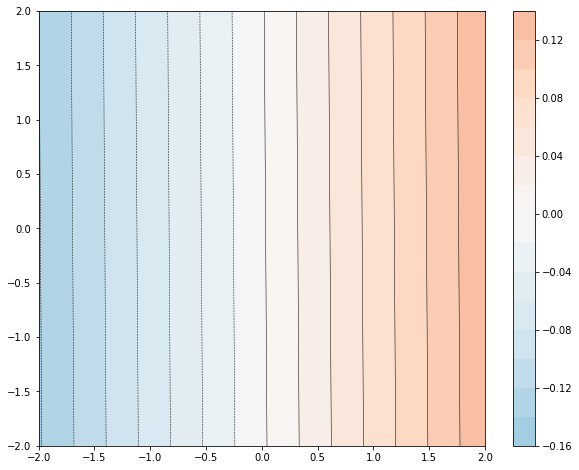

In [39]:
plot_contour(xi, yi, predict(est))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptl77ivnf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


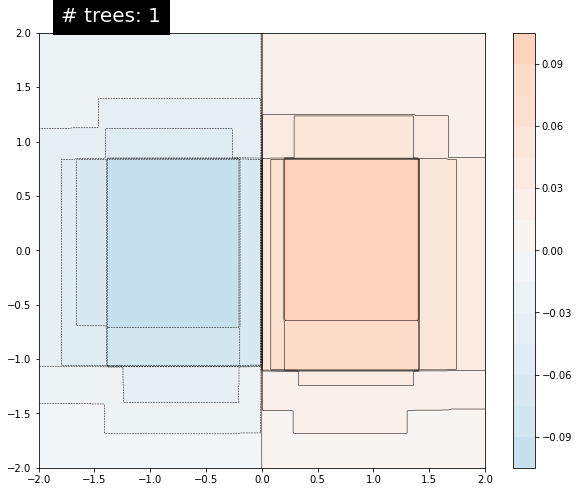

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmprrg_i9mq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


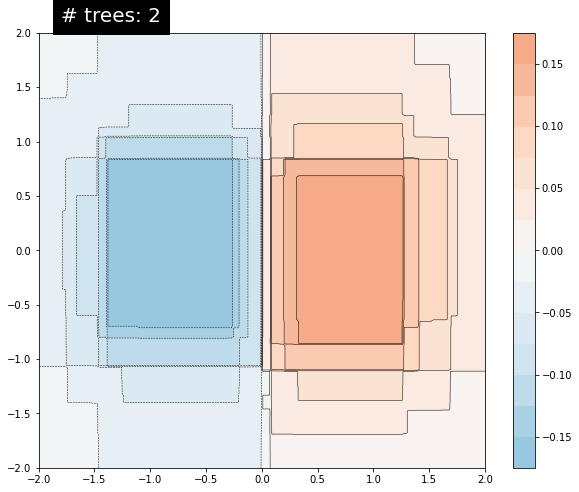

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_bszq7lo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


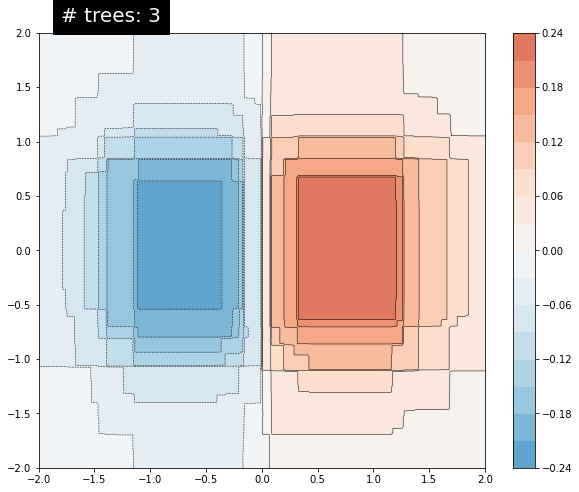

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpju98o866', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


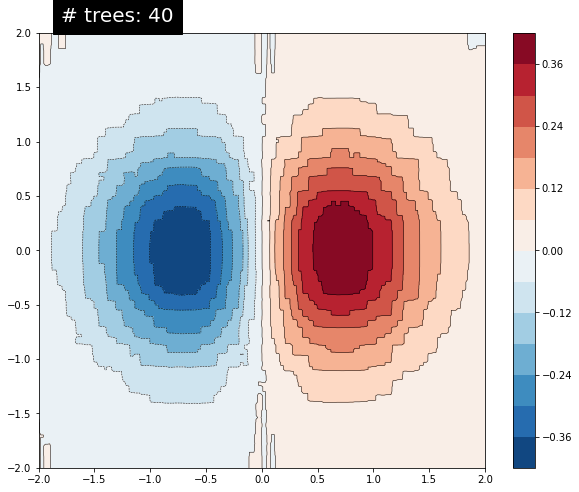

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxphgkfbw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


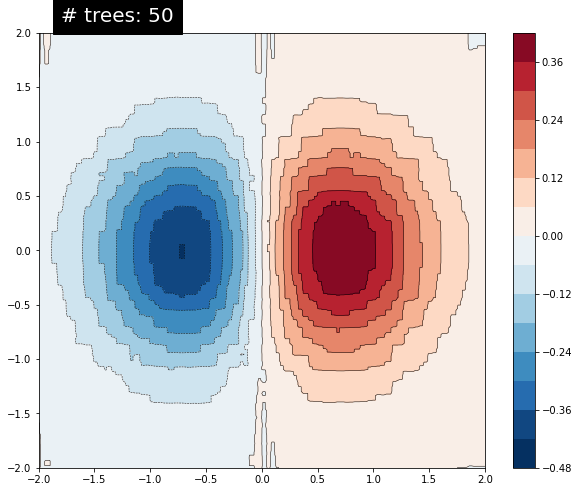

In [43]:
no_trees = [1,2,3,40,50]
for n_trees in no_trees:
  est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
  est.train(train_input_fn, max_steps=500)
  #clear_output()
  plot_contour(xi, yi, predict(est))
  plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
  plt.show()
